In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, BatchNormalization, Activation, add, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import os
import random
import time
import importlib
import pygame as pg

from tqdm.notebook import tqdm

from settings import ROWS, COLUMNS, PLAYER, AI, EMPTY
from board import is_valid_location, get_next_open_row, get_valid_locations, create_board, drop_piece, winning_move
import MCTS
importlib.reload(MCTS)
from MCTS import mcts_search

pygame 2.6.1 (SDL 2.28.4, Python 3.9.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [4]:
try:
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("Đang sử dụng GPU")
    tf.config.run_functions_eagerly(True)
except:
    print("Không tìm thấy GPU, sử dụng CPU")
    tf.config.run_functions_eagerly(True)

In [5]:
class Connect4NeuralNetwork:
    def __init__(self, model_path=None):
        self.model = None
        self.model_path = model_path
        self._prediction_cache = {}
        self.model_ready = False
        
        if model_path and os.path.exists(model_path):
            self.load_model(model_path)
        else:
            self.build_model()
    
    def build_model(self):
        input_shape = (ROWS, COLUMNS, 3)
        inputs = Input(shape=input_shape)
        
        x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.00015))(inputs)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
   
        x = self._residual_block(x, 64)
        x = self._residual_block(x, 64)
        x = self._residual_block(x, 64)
        x = Dropout(0.15)(x)
        x = self._residual_block(x, 128)
        x = Dropout(0.15)(x)
        x = self._residual_block(x, 128)

        policy_head = Conv2D(64, (1, 1), padding='same', kernel_regularizer=l2(0.00015))(x)
        policy_head = BatchNormalization()(policy_head)
        policy_head = Activation('relu')(policy_head)
        policy_head = Conv2D(32, (1, 1), padding='same', kernel_regularizer=l2(0.00015))(policy_head)
        policy_head = BatchNormalization()(policy_head)
        policy_head = Activation('relu')(policy_head)
        policy_head = Flatten()(policy_head)
        policy_head = Dropout(0.275)(policy_head)
        policy_head = Dense(COLUMNS, activation='softmax', name='policy', kernel_regularizer=l2(0.00015))(policy_head)
        
        value_head = Conv2D(64, (1, 1), padding='same', kernel_regularizer=l2(0.00015))(x)
        value_head = BatchNormalization()(value_head)
        value_head = Activation('relu')(value_head)
        value_head = Conv2D(32, (1, 1), padding='same', kernel_regularizer=l2(0.00015))(value_head)
        value_head = BatchNormalization()(value_head)
        value_head = Activation('relu')(value_head)
        value_head = Flatten()(value_head)
        value_head = Dense(64, activation='relu', kernel_regularizer=l2(0.0002))(value_head)
        value_head = Dropout(0.5)(value_head)
        value_head = Dense(32, activation='relu', kernel_regularizer=l2(0.0002))(value_head)
        value_head = Dropout(0.3)(value_head)
        value_head = Dense(1, activation='tanh', name='value', kernel_regularizer=l2(0.0002))(value_head)
        
        self.model = Model(inputs=inputs, outputs=[policy_head, value_head])
        
        self.model.compile(
            optimizer=Adam(learning_rate=0.00006),
            loss={
                'policy': 'categorical_crossentropy',
                'value': 'mean_squared_error'
            },
            loss_weights={
                'policy': 1.2,
                'value': 2.6
            },
            metrics={
                'policy': 'accuracy',
                'value': 'mean_absolute_error'
            }
        )
        
        self.model.summary()
        self.model_ready = True
    
    # Học phần chênh lệch
    def _residual_block(self, x, filters):
        shortcut = x
        
        # x = Conv2D(filters, (3, 3), padding='same')(x)
        x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2(0.00015))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # x = Conv2D(filters, (3, 3), padding='same')(x)
        x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2(0.00015))(x)
        x = BatchNormalization()(x)
        
        x = add([x, shortcut])
        x = Activation('relu')(x)
        
        return x
    
    def _board_to_key(self, board):
        key = []
        for r in range(ROWS):
            for c in range(COLUMNS):
                key.append(str(board[r][c]))
        return "".join(key)
    
    def _board_to_tensor(self, board):
        tensor = np.zeros((ROWS, COLUMNS, 3), dtype=np.float32)
        
        for r in range(ROWS):
            for c in range(COLUMNS):
                if board[r][c] == AI:
                    tensor[r, c, 0] = 1
                elif board[r][c] == PLAYER:
                    tensor[r, c, 1] = 1
                else:  # EMPTY
                    tensor[r, c, 2] = 1
        
        return tensor
    
    def predict(self, board):
        if not self.model_ready:
            default_policy = np.ones(COLUMNS) / COLUMNS
            default_value = 0.0
            return default_policy, default_value
        
        board_key = self._board_to_key(board)
        
        if board_key in self._prediction_cache:
            return self._prediction_cache[board_key]
        
        board_tensor = self._board_to_tensor(board)
        policy, value = self.model.predict(np.expand_dims(board_tensor, axis=0), verbose=0)

        result = (policy[0], value[0][0])
        
        self._prediction_cache[board_key] = result
        
        return result
    
    def clear_cache(self):
        self._prediction_cache = {}
    
    def train(self, boards, policies, values, epochs=15, batch_size=64, validation_split=0.2):
        X = np.array([self._board_to_tensor(board) for board in boards])
        y_policy = np.array(policies, dtype=np.float32)
        y_value = np.array(values, dtype=np.float32).reshape(-1, 1)
        
        callbacks = [
            ModelCheckpoint(
                filepath='models/best_connect4_model.h5',
                save_best_only=True,
                monitor='val_loss',
                mode='min'
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=12,
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.6,
                patience=3,
                min_lr=0.000008
            )
        ]
        
        history = self.model.fit(
            X, 
            {'policy': y_policy, 'value': y_value},
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=callbacks,
            verbose=1
        )
        
        self.clear_cache()
        
        return history
    
    def save_model(self, path='models/connect4_model.h5'):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        self.model.save(path)
        print(f"Model đã được lưu tại {path}")
    
    def load_model(self, path):
        self.model = tf.keras.models.load_model(path)
        print(f"Model đã được tải từ {path}")
        self.model_ready = True

        self.model.compile(
        optimizer=Adam(learning_rate=0.00006), 
        loss={
            'policy': 'categorical_crossentropy',
            'value': 'mean_squared_error'
        },
        loss_weights={
        'policy': 1.2,
        'value': 2.6
        },
        metrics={
            'policy': 'accuracy',
            'value': 'mean_absolute_error'
        }
    )
    
    def generate_training_data(self, mcts_games, augment=True):
        boards = []
        policies = []
        values = []
        
        for board, policy, result in mcts_games:
            boards.append(board)
            policies.append(policy)
            values.append(result)
  
            if augment:
                flipped_board = np.flip(board, axis=1).copy()
                flipped_policy = np.flip(policy).copy()
                boards.append(flipped_board)
                policies.append(flipped_policy)
                values.append(result)
                
                # Thêm nhiễu nhẹ vào policy để tăng tính đa dạng
                if len(policy) > 0:
                    noisy_policy = policy.copy()
                    noise = np.random.normal(0, 0.025, size=policy.shape)
                    for i in range(len(policy)):
                        if policy[i] > 0.03: 
                            noisy_policy[i] += noise[i]
                    noisy_policy = np.maximum(noisy_policy, 0)
                    if np.sum(noisy_policy) > 0:
                        noisy_policy /= np.sum(noisy_policy)
                        boards.append(board)
                        policies.append(noisy_policy)
                        values.append(result)
        
        return boards, policies, values

In [6]:
class Connect4Agent:
    def __init__(self, neural_network=None, model_path=None):

        if neural_network:
            self.nn = neural_network
        else:
            self.nn = Connect4NeuralNetwork(model_path)
        
        self.temperature = 1.0  
        self.batch_size = 32  
    
    def fast_mcts(self, board, num_simulations=2000, temperature_decay=True):
        pieces_count = np.count_nonzero(board != EMPTY)
        total_positions = ROWS * COLUMNS
        game_progress = pieces_count / total_positions  # 0.0 đến 1.0

        if temperature_decay:
            temperature = max(0.2, 1.0 - game_progress * 0.6)
        else:
            temperature = 1.0

        # Điều chỉnh PUCT dựa trên số mô phỏng
        puct_coefficient = 2.0 if num_simulations <= 300 else 1.0
    
        # Chạy MCTS với điều chỉnh PUCT
        move, mcts_policy = mcts_search(board, AI, self.nn, num_simulations, puct_coefficient=puct_coefficient)
    
        if temperature != 1.0:
            mcts_policy = np.power(mcts_policy + 1e-10, 1.0/temperature)
            mcts_policy /= np.sum(mcts_policy)
    
        return move, mcts_policy

In [6]:
import ai
importlib.reload(ai)
from ai import minimax
from settings import AI_DIFFICULTY
import math

In [12]:
# def collect_self_play_data(agent, num_games=50, mcts_simulations=2000):
#     training_data = []
#     win_stats = {'AI': 0, 'PLAYER': 0, 'DRAW': 0}
    
#     # Khởi tạo Pygame một lần
#     pg.init()
#     pg.font.init()
#     screen = pg.display.set_mode((SQUARE_SIZE * COLUMNS, (ROWS + 1) * SQUARE_SIZE))
#     pg.display.set_caption("Collect Self-Play Data")
#     background = create_gradient_background()
#     clock = pg.time.Clock()
    
#     for game_idx in tqdm(range(num_games), desc="Self-play games"):
#         board = create_board()
#         game_memory = []
#         current_player = AI if game_idx % 2 == 0 else PLAYER  # Luân phiên người đi trước
        
#         game_start_time = time.time()
        
#         # Vẽ bàn cờ ban đầu
#         draw_board(screen, board, background)
        
#         # Hiển thị thông tin trò chơi
#         font = pg.font.SysFont('Arial', 20)
#         text = font.render(f"Game {game_idx+1}/{num_games} - Current: {'NN' if current_player == AI else 'MCTS'}", True, (255, 255, 255))
#         screen.blit(text, (10, 10))
        
#         pg.display.update()
        
#         game_over = False
        
#         while not game_over:
#             # Xử lý sự kiện để tránh treo
#             for event in pg.event.get():
#                 if event.type == pg.QUIT:
#                     pg.quit()
#                     sys.exit()
#                 if event.type == pg.KEYDOWN and event.key == pg.K_ESCAPE:
#                     pg.quit()
#                     sys.exit()
            
#             valid_moves = get_valid_locations(board)
            
#             if not valid_moves:  
#                 result = 0.0
#                 win_stats['DRAW'] += 1
#                 # Hiển thị kết quả hòa
#                 text = font.render("Draw game!", True, (255, 200, 0))
#                 screen.blit(text, (SQUARE_SIZE * COLUMNS // 2 - 60, 10))
#                 pg.display.update()
#                 time.sleep(1.0)  # Tạm dừng để xem kết quả
#                 game_over = True
#                 break
                
#             # Hiển thị người chơi hiện tại
#             pg.draw.rect(screen, (0, 0, 0), (0, 0, SQUARE_SIZE * COLUMNS, 40))
#             text = font.render(f"Game {game_idx+1}/{num_games} - Current: {'NN' if current_player == AI else 'MCTS'}", True, (255, 255, 255))
#             screen.blit(text, (10, 10))
#             pg.display.update()
            
#             # Đợi một chút để có thể quan sát
#             time.sleep(0.3)
            
#             if current_player == AI:
#                 # NN luôn đóng vai AI (quân 2), không cần chuyển đổi
#                 move, mcts_policy = agent.fast_mcts(board, mcts_simulations, temperature_decay=True)
#                 game_memory.append((board.copy(), mcts_policy, AI))
#             else:
#                 # MCTS thuần đóng vai PLAYER (quân 1), cần chuyển đổi bàn cờ
#                 # Chuyển đổi bàn cờ để MCTS thuần luôn nghĩ nó là AI (quân 2)
#                 reversed_board = board.copy()
#                 reversed_board = np.where(reversed_board == AI, -1, reversed_board)      # Tạm đổi AI (2) → -1
#                 reversed_board = np.where(reversed_board == PLAYER, AI, reversed_board)  # PLAYER (1) → AI (2)
#                 reversed_board = np.where(reversed_board == -1, PLAYER, reversed_board)  # -1 (tạm) → PLAYER (1)
                
#                 # Gọi MCTS với bàn cờ đã chuyển đổi, MCTS sẽ nghĩ nó là AI (2)
#                 move, reversed_policy = mcts_search(reversed_board, AI, neural_network=None, simulations=20000)
                
#                 # Policy không cần đảo ngược vì nó dựa trên số cột
#                 mcts_policy = reversed_policy
                
#                 game_memory.append((board.copy(), mcts_policy, PLAYER))
            
#             row = get_next_open_row(board, move)
            
#             # Hiệu ứng rơi quân cờ
#             animate_piece_drop(screen, board, row, move, current_player, background, 15)
            
#             # Cập nhật bảng sau khi quân cờ rơi xuống
#             drop_piece(board, row, move, current_player)
#             draw_board(screen, board, background)
            
#             # Hiển thị nước đi vừa thực hiện  
#             pg.draw.rect(screen, (0, 0, 0), (SQUARE_SIZE * COLUMNS - 150, 10, 140, 30))
#             text = font.render(f"Move: Column {move+1}", True, (200, 200, 200))
#             screen.blit(text, (SQUARE_SIZE * COLUMNS - 140, 10))
#             pg.display.update()
            
#             win, winning_cells = winning_move(board, current_player)
#             if win:
#                 # Vẽ các ô thắng cuộc
#                 draw_board(screen, board, background, None, None, winning_cells)
                
#                 if current_player == AI:
#                     result = 1.0
#                     win_stats['AI'] += 1
#                     text = font.render("NN wins!", True, (100, 200, 255))
#                 else:
#                     result = -1.0
#                     win_stats['PLAYER'] += 1
#                     text = font.render("MCTS wins!", True, (255, 100, 100))
                
#                 pg.draw.rect(screen, (0, 0, 0), (SQUARE_SIZE * COLUMNS // 2 - 70, 10, 140, 30))
#                 screen.blit(text, (SQUARE_SIZE * COLUMNS // 2 - 60, 10))
#                 pg.display.update()
#                 time.sleep(1.5)  # Tạm dừng để xem kết quả
#                 game_over = True
#                 break
                
#             current_player = PLAYER if current_player == AI else AI
            
#             # Giới hạn tốc độ khung hình
#             clock.tick(60)
        
#         for board_state, policy, player in game_memory:
#             if player == AI:
#                 training_data.append((board_state, policy, result))
#             else:
#                 training_data.append((board_state, policy, -result))
        
#         game_time = time.time() - game_start_time
#         print(f"Game {game_idx+1} hoàn thành trong {game_time:.1f}s: {'AI' if result > 0 else 'PLAYER' if result < 0 else 'HOÀ'}")
        
#         if (game_idx + 1) % 5 == 0:
#             print(f"Thống kê sau {game_idx + 1} trò chơi:")
#             print(f"NN thắng: {win_stats['AI']} ({win_stats['AI']/(game_idx+1)*100:.1f}%)")
#             print(f"MCTS thắng: {win_stats['PLAYER']} ({win_stats['PLAYER']/(game_idx+1)*100:.1f}%)")
#             print(f"Hoà: {win_stats['DRAW']} ({win_stats['DRAW']/(game_idx+1)*100:.1f}%)")
    
#     print(f"Thống kê cuối cùng - NN thắng: {win_stats['AI']}, MCTS thắng: {win_stats['PLAYER']}, Hoà: {win_stats['DRAW']}")
#     pg.quit()
#     return training_data



def collect_self_play_data(agent, num_games=50, mcts_simulations=2000):
    training_data = []
    win_stats = {'AI': 0, 'MINIMAX': 0, 'DRAW': 0}
    
    # Khởi tạo Pygame một lần
    pg.init()
    pg.font.init()
    screen = pg.display.set_mode((SQUARE_SIZE * COLUMNS, (ROWS + 1) * SQUARE_SIZE))
    pg.display.set_caption("Collect Self-Play Data vs Minimax")
    background = create_gradient_background()
    clock = pg.time.Clock()
    
    for game_idx in tqdm(range(num_games), desc="Self-play games"):
        board = create_board()
        game_memory = []
        current_player = AI if game_idx % 2 == 0 else PLAYER  # Luân phiên người đi trước
        
        game_start_time = time.time()
        
        # Vẽ bàn cờ ban đầu
        draw_board(screen, board, background)
        
        # Hiển thị thông tin trò chơi
        font = pg.font.SysFont('Arial', 20)
        text = font.render(f"Game {game_idx+1}/{num_games} - Current: {'NN' if current_player == AI else 'Minimax'}", True, (255, 255, 255))
        screen.blit(text, (10, 10))
        
        pg.display.update()
        
        game_over = False
        
        while not game_over:
            # Xử lý sự kiện để tránh treo
            for event in pg.event.get():
                if event.type == pg.QUIT:
                    pg.quit()
                    sys.exit()
                if event.type == pg.KEYDOWN and event.key == pg.K_ESCAPE:
                    pg.quit()
                    sys.exit()
            
            valid_moves = get_valid_locations(board)
            
            if not valid_moves:  
                result = 0.0
                win_stats['DRAW'] += 1
                # Hiển thị kết quả hòa
                text = font.render("Draw game!", True, (255, 200, 0))
                screen.blit(text, (SQUARE_SIZE * COLUMNS // 2 - 60, 10))
                pg.display.update()
                time.sleep(1.0)  # Tạm dừng để xem kết quả
                game_over = True
                break
                
            # Hiển thị người chơi hiện tại
            pg.draw.rect(screen, (0, 0, 0), (0, 0, SQUARE_SIZE * COLUMNS, 40))
            text = font.render(f"Game {game_idx+1}/{num_games} - Current: {'NN' if current_player == AI else 'Minimax'}", True, (255, 255, 255))
            screen.blit(text, (10, 10))
            pg.display.update()
            
            # Đợi một chút để có thể quan sát
            time.sleep(0.3)
            
            if current_player == AI:
                # NN luôn đóng vai AI (quân 2), không cần chuyển đổi
                move, mcts_policy = agent.fast_mcts(board, mcts_simulations, temperature_decay=True)
                game_memory.append((board.copy(), mcts_policy, AI))
            else:
                # Minimax đóng vai PLAYER (quân 1), cần chuyển đổi bàn cờ
                # Chuyển đổi bàn cờ để Minimax luôn nghĩ nó là AI (quân 2)
                reversed_board = board.copy()
                reversed_board = np.where(reversed_board == AI, -1, reversed_board)      # Tạm đổi AI (2) → -1
                reversed_board = np.where(reversed_board == PLAYER, AI, reversed_board)  # PLAYER (1) → AI (2)
                reversed_board = np.where(reversed_board == -1, PLAYER, reversed_board)  # -1 (tạm) → PLAYER (1)
                
                # Gọi Minimax với bàn cờ đã chuyển đổi, Minimax sẽ nghĩ nó là AI (2)
                # move, minimax_policy = minimax(reversed_board, AI_DIFFICULTY, -math.inf, math.inf, True)
                move, minimax_policy = mcts_search(board, AI, neural_network=None, simulations=20000)
                
                # Policy không cần đảo ngược vì nó dựa trên số cột
                game_memory.append((board.copy(), minimax_policy, PLAYER))
            
            row = get_next_open_row(board, move)
            
            # Hiệu ứng rơi quân cờ
            animate_piece_drop(screen, board, row, move, current_player, background, 15)
            
            # Cập nhật bảng sau khi quân cờ rơi xuống
            drop_piece(board, row, move, current_player)
            draw_board(screen, board, background)
            
            # Hiển thị nước đi vừa thực hiện  
            pg.draw.rect(screen, (0, 0, 0), (SQUARE_SIZE * COLUMNS - 150, 10, 140, 30))
            text = font.render(f"Move: Column {move+1}", True, (200, 200, 200))
            screen.blit(text, (SQUARE_SIZE * COLUMNS - 140, 10))
            pg.display.update()
            
            win, winning_cells = winning_move(board, current_player)
            if win:
                # Vẽ các ô thắng cuộc
                draw_board(screen, board, background, None, None, winning_cells)
                
                if current_player == AI:
                    result = 1.0
                    win_stats['AI'] += 1
                    text = font.render("NN wins!", True, (100, 200, 255))
                else:
                    result = -1.0
                    win_stats['MINIMAX'] += 1
                    text = font.render("Minimax wins!", True, (255, 100, 100))
                
                pg.draw.rect(screen, (0, 0, 0), (SQUARE_SIZE * COLUMNS // 2 - 70, 10, 140, 30))
                screen.blit(text, (SQUARE_SIZE * COLUMNS // 2 - 60, 10))
                pg.display.update()
                time.sleep(1.5)  # Tạm dừng để xem kết quả
                game_over = True
                break
                
            current_player = PLAYER if current_player == AI else AI
            
            # Giới hạn tốc độ khung hình
            clock.tick(60)
        
        for board_state, policy, player in game_memory:
            if player == AI:
                training_data.append((board_state, policy, result))
            else:
                training_data.append((board_state, policy, -result))
        
        game_time = time.time() - game_start_time
        print(f"Game {game_idx+1} hoàn thành trong {game_time:.1f}s: {'AI' if result > 0 else 'MINIMAX' if result < 0 else 'HOÀ'}")
        
        if (game_idx + 1) % 5 == 0:
            print(f"Thống kê sau {game_idx + 1} trò chơi:")
            print(f"NN thắng: {win_stats['AI']} ({win_stats['AI']/(game_idx+1)*100:.1f}%)")
            print(f"Minimax thắng: {win_stats['MINIMAX']} ({win_stats['MINIMAX']/(game_idx+1)*100:.1f}%)")
            print(f"Hoà: {win_stats['DRAW']} ({win_stats['DRAW']/(game_idx+1)*100:.1f}%)")
    
    print(f"Thống kê cuối cùng - NN thắng: {win_stats['AI']}, Minimax thắng: {win_stats['MINIMAX']}, Hoà: {win_stats['DRAW']}")
    pg.quit()
    return training_data



In [7]:
def train_model_cycle(cycles=5, games_per_cycle=50, epochs_per_cycle=15, mcts_simulations=2000):
    model_path = 'models/connect4_model.h5' if os.path.exists('models/connect4_model.h5') else None
    nn = Connect4NeuralNetwork(model_path)
    agent = Connect4Agent(nn)
    
    training_history = []
    
    for cycle in range(cycles):
        cycle_start_time = time.time()
        print(f"=== Bắt đầu chu kỳ {cycle + 1}/{cycles} ===")
        
        # Thu thập dữ liệu từ tự chơi
        print("Thu thập dữ liệu tự chơi...")
        training_data = collect_self_play_data(agent, num_games=games_per_cycle, mcts_simulations=mcts_simulations)
        
        # Chuẩn bị dữ liệu huấn luyện
        boards, policies, values = nn.generate_training_data(training_data)
        
        print(f"Dữ liệu thu thập: {len(boards)} vị trí")
        
        print("Huấn luyện neural network...")
        history = nn.train(boards, policies, values, epochs=epochs_per_cycle, batch_size=32)
        training_history.append(history)
        
        nn.save_model(f'models/connect4_model_cycle_{cycle + 1}.h5')
        nn.save_model('models/connect4_model.h5') 
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['policy_accuracy'])
        plt.plot(history.history['val_policy_accuracy'])
        plt.title('Policy Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['value_mean_absolute_error'])
        plt.plot(history.history['val_value_mean_absolute_error'])
        plt.title('Value MAE')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.tight_layout()
        plt.savefig(f'models/training_cycle_{cycle + 1}.png')
        plt.show()
        
        cycle_time = time.time() - cycle_start_time
        print(f"Chu kỳ {cycle + 1} hoàn thành trong {cycle_time/60:.2f} phút")
    
    return nn, training_history

In [9]:
import pygame as pg
import sys
from time import sleep
import random as rd

from settings import *

from importlib import reload
import utils
reload(utils)
from utils import create_gradient_background, draw_board, animate_piece_drop, show_game_over

In [10]:
def evaluate_model(agent, num_games=20, opponent='mcts'):
    win_stats = {'Agent': 0, 'Opponent': 0, 'Draw': 0}
    
    for game_idx in tqdm(range(num_games), desc="Evaluation games"):
        board = create_board()

        agent_first = game_idx % 2 == 0
        current_player = AI if agent_first else PLAYER
        
        while True:
            valid_moves = get_valid_locations(board)
            
            if not valid_moves: 
                win_stats['Draw'] += 1
                break
                
            if (current_player == AI and agent_first) or (current_player == PLAYER and not agent_first):
                if opponent == 'mcts':
                    move, _ = mcts_search(board, AI, neural_network=None)
                else:
                    move = random.choice(valid_moves)
            else:
                move, _ = agent.fast_mcts(board, 300, temperature_decay=False)
            
            row = get_next_open_row(board, move)
            drop_piece(board, row, move, current_player)
            
            if winning_move(board, current_player)[0]:
                if (current_player == AI and agent_first) or (current_player == PLAYER and not agent_first):
                    win_stats['Opponent'] += 1
                else:
                    win_stats['Agent'] += 1
                break
                
            current_player = PLAYER if current_player == AI else AI
    
    print(f"Kết quả đánh giá với {opponent}:")
    print(f"Agent thắng: {win_stats['Agent']} ({win_stats['Agent']/num_games*100:.1f}%)")
    print(f"Opponent thắng: {win_stats['Opponent']} ({win_stats['Opponent']/num_games*100:.1f}%)")
    print(f"Hoà: {win_stats['Draw']} ({win_stats['Draw']/num_games*100:.1f}%)")
    
    return win_stats


Model đã được tải từ models/connect4_model.h5
=== Bắt đầu chu kỳ 1/3 ===
Thu thập dữ liệu tự chơi...


Self-play games:   0%|          | 0/50 [00:00<?, ?it/s]

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0.]]
MCTS: 20000 mô phỏng trong 4.604s
  Cột 3: 18212 lần thăm, tỷ lệ thắng: 0.799
  Cột 0: 451 lần thăm, tỷ lệ thắng: 0.710
  Cột 4: 447 lần thăm, tỷ lệ thắng: 0.642
  Cột 6: 394 lần thăm, tỷ lệ thắng: 0.695
  Cột 1: 368 lần thăm, tỷ lệ thắng: 0.655
  Cột 5: 69 lần thăm, tỷ lệ thắng: 0.348
  Cột 2: 59 lần thăm, tỷ lệ thắng: 0.271
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0.]]


/Users/trananhtuan/Library/Python/3.9/lib/python/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


MCTS: 100 mô phỏng trong 2.680s
  Cột 3: 88 lần thăm, tỷ lệ thắng: 0.257
  Cột 1: 4 lần thăm, tỷ lệ thắng: -0.015
  Cột 2: 2 lần thăm, tỷ lệ thắng: -0.165
  Cột 4: 2 lần thăm, tỷ lệ thắng: -0.112
  Cột 5: 2 lần thăm, tỷ lệ thắng: -0.171
  Cột 0: 1 lần thăm, tỷ lệ thắng: 0.000
  Cột 6: 1 lần thăm, tỷ lệ thắng: 0.000
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0.]]
MCTS: 20000 mô phỏng trong 4.716s
  Cột 3: 14303 lần thăm, tỷ lệ thắng: 0.612
  Cột 2: 1107 lần thăm, tỷ lệ thắng: 0.525
  Cột 0: 1008 lần thăm, tỷ lệ thắng: 0.585
  Cột 1: 962 lần thăm, tỷ lệ thắng: 0.549
  Cột 4: 913 lần thăm, tỷ lệ thắng: 0.512
  Cột 5: 879 lần thăm, tỷ lệ thắng: 0.543
  Cột 6: 828 lần thăm, tỷ lệ thắng: 0.571
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0.]]
MCTS: 100 mô phỏng trong 2.421s
  Cột 4: 73 lần thăm, tỷ lệ t

83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 4.3572 - policy_accuracy: 0.4492 - policy_loss: 1.5813 - value_loss: 0.9460 - value_mean_absolute_error: 0.8592 - val_loss: 4.4084 - val_policy_accuracy: 0.4409 - val_policy_loss: 1.5412 - val_value_loss: 0.9842 - val_value_mean_absolute_error: 0.8608 - learning_rate: 6.0000e-05
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 4.0056 - policy_accuracy: 0.5071 - policy_loss: 1.5023 - value_loss: 0.8472 - value_mean_absolute_error: 0.7970

83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 4.0052 - policy_accuracy: 0.5069 - policy_loss: 1.5024 - value_loss: 0.8470 - value_mean_absolute_error: 0.7969 - val_loss: 4.2894 - val_policy_accuracy: 0.4485 - val_policy_loss: 1.5305 - val_value_loss: 0.9434 - val_value_mean_absolute_error: 0.8468 - learning_rate: 6.0000e-05
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.8744 - policy_accuracy: 0.4976 - policy_loss: 1.4996 - value_loss: 0.7980 - value_mean_absolute_error: 0.7642

83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 3.8737 - policy_accuracy: 0.4976 - policy_loss: 1.4995 - value_loss: 0.7978 - value_mean_absolute_error: 0.7641 - val_loss: 4.2283 - val_policy_accuracy: 0.4530 - val_policy_loss: 1.5237 - val_value_loss: 0.9230 - val_value_mean_absolute_error: 0.8303 - learning_rate: 6.0000e-05
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.7341 - policy_accuracy: 0.5258 - policy_loss: 1.4737 - value_loss: 0.7560 - value_mean_absolute_error: 0.7341

83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 3.7339 - policy_accuracy: 0.5256 - policy_loss: 1.4737 - value_loss: 0.7560 - value_mean_absolute_error: 0.7341 - val_loss: 4.1937 - val_policy_accuracy: 0.4545 - val_policy_loss: 1.5158 - val_value_loss: 0.9134 - val_value_mean_absolute_error: 0.8414 - learning_rate: 6.0000e-05
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 3.6830 - policy_accuracy: 0.5221 - policy_loss: 1.4657 - value_loss: 0.7400 - value_mean_absolute_error: 0.7266

83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 3.6827 - policy_accuracy: 0.5220 - policy_loss: 1.4656 - value_loss: 0.7400 - value_mean_absolute_error: 0.7266 - val_loss: 4.1373 - val_policy_accuracy: 0.4545 - val_policy_loss: 1.5067 - val_value_loss: 0.8959 - val_value_mean_absolute_error: 0.8293 - learning_rate: 6.0000e-05
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 3.5521 - policy_accuracy: 0.5284 - policy_loss: 1.4418 - value_loss: 0.7007 - value_mean_absolute_error: 0.7005 - val_loss: 4.1411 - val_policy_accuracy: 0.4621 - val_policy_loss: 1.5066 - val_value_loss: 0.8974 - val_value_mean_absolute_error: 0.8392 - learning_rate: 6.0000e-05
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 3.5617 - policy_accuracy: 0.5465 - policy_loss: 1.4344 - value_loss: 0.7078 - value_mean_absolute_error: 0.7166

83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 3.5613 - policy_accuracy: 0.5464 - policy_loss: 1.4344 - value_loss: 0.7077 - value_mean_absolute_error: 0.7165 - val_loss: 4.1343 - val_policy_accuracy: 0.4530 - val_policy_loss: 1.5056 - val_value_loss: 0.8952 - val_value_mean_absolute_error: 0.8229 - learning_rate: 6.0000e-05
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 3.4582 - policy_accuracy: 0.5529 - policy_loss: 1.4176 - value_loss: 0.6758 - value_mean_absolute_error: 0.6818

83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 3.4581 - policy_accuracy: 0.5528 - policy_loss: 1.4176 - value_loss: 0.6758 - value_mean_absolute_error: 0.6818 - val_loss: 4.0825 - val_policy_accuracy: 0.4591 - val_policy_loss: 1.5038 - val_value_loss: 0.8761 - val_value_mean_absolute_error: 0.8148 - learning_rate: 6.0000e-05
Epoch 9/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 3.4265 - policy_accuracy: 0.5546 - policy_loss: 1.4002 - value_loss: 0.6716 - value_mean_absolute_error: 0.6832

83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 3.4264 - policy_accuracy: 0.5546 - policy_loss: 1.4003 - value_loss: 0.6716 - value_mean_absolute_error: 0.6832 - val_loss: 4.0779 - val_policy_accuracy: 0.4576 - val_policy_loss: 1.4991 - val_value_loss: 0.8765 - val_value_mean_absolute_error: 0.8273 - learning_rate: 6.0000e-05
Epoch 10/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 3.3381 - policy_accuracy: 0.5557 - policy_loss: 1.3886 - value_loss: 0.6430 - value_mean_absolute_error: 0.6773 - val_loss: 4.1286 - val_policy_accuracy: 0.4636 - val_policy_loss: 1.5018 - val_value_loss: 0.8948 - val_value_mean_absolute_error: 0.8167 - learning_rate: 6.0000e-05
Epoch 11/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 3.2767 - policy_accuracy: 0.5630 - policy_loss: 1.3812 - value_loss: 0.6228 - value_mean_absolute_error: 0.6610 - val_loss: 4.1159 - val_policy_accuracy: 0.4652 - val_policy_loss: 1.5007 - val_value_loss: 0.8904 - val_value_mean_absolute_error: 0.8151 - learning_rate: 6.0

Model đã được lưu tại models/connect4_model_cycle_1.h5
Model đã được lưu tại models/connect4_model.h5


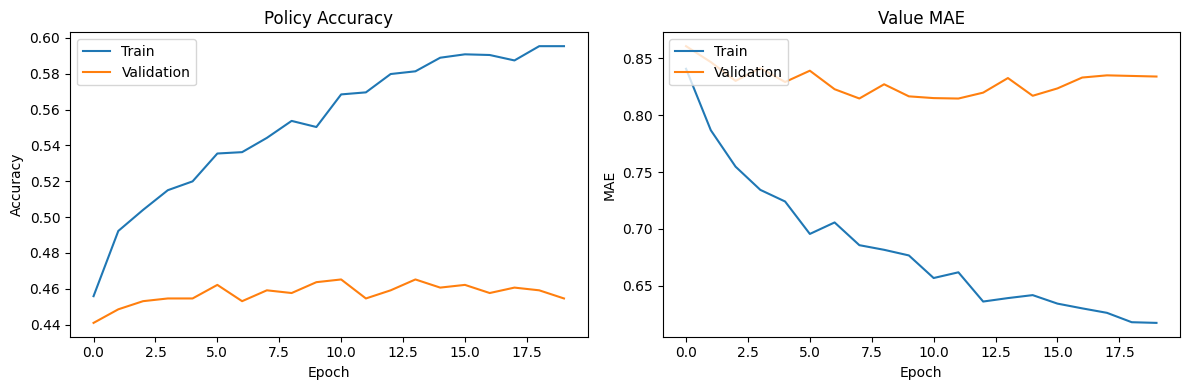

Chu kỳ 1 hoàn thành trong 59.70 phút
=== Bắt đầu chu kỳ 2/3 ===
Thu thập dữ liệu tự chơi...


Self-play games:   0%|          | 0/50 [00:00<?, ?it/s]

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0.]]
MCTS: 20000 mô phỏng trong 4.799s
  Cột 3: 17794 lần thăm, tỷ lệ thắng: 0.806
  Cột 4: 488 lần thăm, tỷ lệ thắng: 0.660
  Cột 2: 451 lần thăm, tỷ lệ thắng: 0.652
  Cột 5: 438 lần thăm, tỷ lệ thắng: 0.683
  Cột 0: 401 lần thăm, tỷ lệ thắng: 0.706
  Cột 1: 365 lần thăm, tỷ lệ thắng: 0.663
  Cột 6: 63 lần thăm, tỷ lệ thắng: 0.365
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0.]]
MCTS: 100 mô phỏng trong 3.773s
  Cột 2: 80 lần thăm, tỷ lệ thắng: 0.252
  Cột 3: 8 lần thăm, tỷ lệ thắng: 0.003
  Cột 0: 4 lần thăm, tỷ lệ thắng: 0.135
  Cột 1: 3 lần thăm, tỷ lệ thắng: 0.138
  Cột 5: 2 lần thăm, tỷ lệ thắng: -0.006
  

In [13]:
nn, history = train_model_cycle(cycles=3, games_per_cycle=50, epochs_per_cycle=20, mcts_simulations=100)
agent = Connect4Agent(nn)

In [ ]:
nn = Connect4NeuralNetwork('models/connect4_model.h5')
agent = Connect4Agent(nn)
results_vs_mcts = evaluate_model(agent, num_games=1, opponent='mcts')

In [ ]:
from ai_battle import main

nn = Connect4NeuralNetwork('models/connect4_model.h5')
agent = Connect4Agent(nn)
main(agent)

In [17]:
# import pickle

# with open('models/evaluation_results.pkl', 'wb') as f:
#     pickle.dump({'vs_mcts': results_vs_mcts}, f)

# with open('models/training_history.pkl', 'wb') as f:
#     pickle.dump(history, f)

# print("Quá trình huấn luyện hoàn thành và đã lưu kết quả!")

Quá trình huấn luyện hoàn thành và đã lưu kết quả!


In [44]:
# import shutil
# shutil.copy('models/connect4_model_cycle_1.h5', 'models/connect4_model_backup.h5')

'models/connect4_model_backup.h5'

In [113]:
# import shutil
# import os

# if os.path.exists('models/connect4_model_debug.h5'):
#     shutil.copy('models/connect4_model.h5', 'models/connect4_model_backup.h5')